# LSTM time series and zero-mean data.

### Part A:

Main steps:
1. Preprocessing
    * Make data stationary
    * Normalize the data
    * Map data to supervised setting using a sliding window
2. Split into training and test sets
3. Use a 2-layer LSTM to model

### Part B: 

Repeat the above but now modeling the differentiated data. By taking the finite difference we remove the moving mean from the data. We will see that model improves significantly. This is related to the fact that some time series models
perform better with stationary data. 





In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

SEED = 0

torch.use_deterministic_algorithms(True)

# Dataset

In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2021-08-25 18:47:06--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2021-08-25 18:47:06 (33.1 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [148]:
training_set = pd.read_csv('/content/airline-passengers.csv')
training_set.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


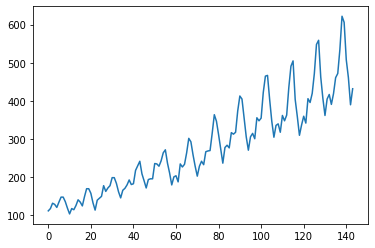

In [149]:
training_set = training_set.Passengers.values
plt.plot(training_set)
plt.show()

# Dataloading

The function `sliding_windows` converts the time series into a labeled set.

In [5]:
def sliding_windows(data, window_length, return_target=True):
    """
    Function to create consecutive sequences of equal length
    and step 1.

    Args:
        data: 1D array to extract windows
        window_length: window size (diameter)
        return_target: set to True to obtain the end point of each window as
            as a target value

    """
    window = np.arange(window_length)[None,:]    # shape = (1, window_length)
    max_time = len(data) - len(window[0]) + 1
    steps = np.arange(max_time)[None,:].T     # shape = (max_time, 1)
    slices = window + steps                   # shape = (max_time, window_length)
    

    if return_target:
        target = data[np.array(slices)[:,2][None,:].T][:,:,0]
        return data[slices], target

    return data[slices]

In [150]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_set.reshape(-1,1))
x, y = sliding_windows(training_data, 4)

train_size = int(len(y) * 0.66)
test_size = len(y) - train_size

dataX = torch.tensor(np.array(x), requires_grad=False)
dataY = torch.tensor(np.array(y), requires_grad=False)

trainX = torch.tensor(np.array(x[:train_size]), requires_grad=True)
trainY = torch.tensor(np.array(y[:train_size]), requires_grad=True)

testX = torch.tensor(np.array(x[train_size:]), requires_grad=True).double()
testY = torch.tensor(np.array(y[train_size:]), requires_grad=True).double()

# Model

In [133]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):

        super().__init__()

        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5) 
        self.collapse = nn.Linear(self.num_layers, 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True).double()
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True).double()

        _, (h_out, _) = self.lstm(x, (h_0, c_0))

        out = h_out.transpose(0,2)
        out = self.collapse(out).squeeze()
        out = self.fc(out.T.view(-1, self.hidden_size))
        
        return out

# Training

In [151]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 2

num_classes = 1

torch.manual_seed(SEED)
lstm = LSTM(num_classes, input_size, hidden_size, num_layers).double()

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
loss_iter = []
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_iter.append(loss.detach().cpu().item())
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.10212
Epoch: 100, loss: 0.01442
Epoch: 200, loss: 0.00059
Epoch: 300, loss: 0.00057
Epoch: 400, loss: 0.00053
Epoch: 500, loss: 0.00052
Epoch: 600, loss: 0.00048
Epoch: 700, loss: 0.00042
Epoch: 800, loss: 0.00027
Epoch: 900, loss: 0.00008
Epoch: 1000, loss: 0.00005
Epoch: 1100, loss: 0.00004
Epoch: 1200, loss: 0.00003
Epoch: 1300, loss: 0.00002
Epoch: 1400, loss: 0.00002
Epoch: 1500, loss: 0.00001
Epoch: 1600, loss: 0.00001
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00001
Epoch: 1900, loss: 0.00001


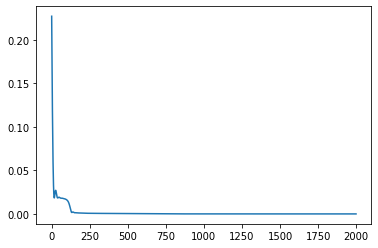

In [9]:
plt.plot(loss_iter)
plt.show()

# Inference

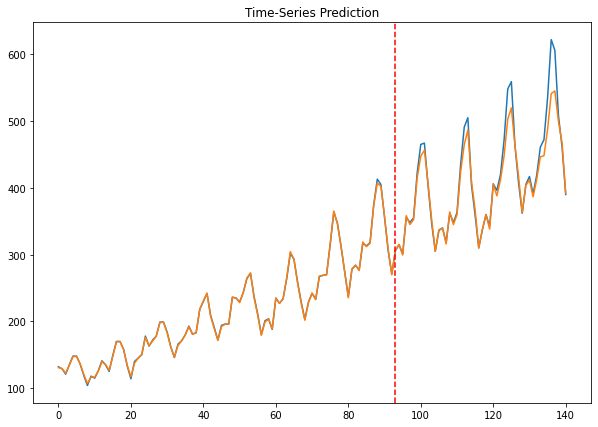

In [152]:
lstm.eval()
train_pred = lstm(dataX)

plt.figure(figsize=(10,7))
plt.plot(scaler.inverse_transform(dataY))
plt.plot(scaler.inverse_transform(train_pred.detach()))

plt.axvline(x=train_size, c='r', linestyle='--')
plt.title('Time-Series Prediction')
plt.show()

# Part B: Repeated exercise, but removing the trend

Sometimes it can be helpful to remove any monotonic trends by differentiation. This step makes the data more stationary, but since the variance is still time dependent I don't think the differentiated is a true stationary time series.

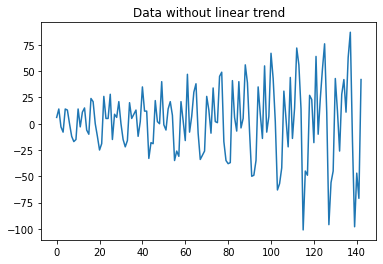

In [134]:
training_set = pd.read_csv('/content/airline-passengers.csv')
training_set = training_set.Passengers.values
initial_value = training_set[0]
training_set = np.diff(training_set)  # differenttiate

plt.plot(training_set)
plt.title('Data without linear trend')
plt.show()

In [135]:
# preprocess and data split
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_set.reshape(-1,1))
x, y = sliding_windows(training_data, 4)

train_size = int(len(y) * 0.66)
test_size = len(y) - train_size

dataX = torch.tensor(np.array(x), requires_grad=False)
dataY = torch.tensor(np.array(y), requires_grad=False)

trainX = torch.tensor(np.array(x[:train_size]), requires_grad=True)
trainY = torch.tensor(np.array(y[:train_size]), requires_grad=True)

testX = torch.tensor(np.array(x[train_size:]), requires_grad=True).double()
testY = torch.tensor(np.array(y[train_size:]), requires_grad=True).double()

In [144]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 2

num_classes = 1

torch.manual_seed(SEED)
lstm = LSTM(num_classes, input_size, hidden_size, num_layers).double()

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
loss_iter = []
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss_iter.append(loss.detach().cpu().item())
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.01669
Epoch: 100, loss: 0.00645
Epoch: 200, loss: 0.00035
Epoch: 300, loss: 0.00004
Epoch: 400, loss: 0.00002
Epoch: 500, loss: 0.00002
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00001
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00003
Epoch: 1000, loss: 0.00001
Epoch: 1100, loss: 0.00007
Epoch: 1200, loss: 0.00001
Epoch: 1300, loss: 0.00001
Epoch: 1400, loss: 0.00001
Epoch: 1500, loss: 0.00001
Epoch: 1600, loss: 0.00001
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00001
Epoch: 1900, loss: 0.00001


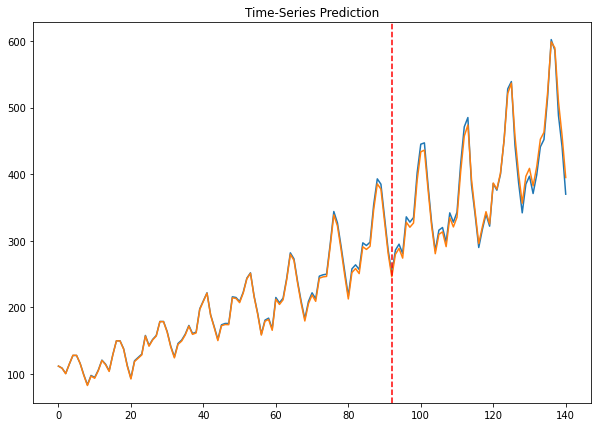

In [145]:
lstm.eval()
pred = lstm(dataX)

YY = scaler.inverse_transform(dataY) # reverse scaling
YY = np.r_[initial_value, YY.T.squeeze()].cumsum() # integrate

prediction = np.r_[initial_value, scaler.inverse_transform(pred.detach()).T.squeeze()].cumsum()

plt.figure(figsize=(10,7))
plt.plot(YY)
plt.plot(prediction)

plt.axvline(x=train_size, c='r', linestyle='--')
plt.title('Time-Series Prediction')
plt.show()